# Atelier 1 : Prise en main du modèle GPT2
### Réglage Fin du LLM pour générer le prochain token

# 1 - GPT2 Model

**Pytorch libraries**

In [ ]:
#Pytorch libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

**Device set up**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Loading Tokenizer**

In [ ]:
#tokenization library
!pip install tiktoken
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))
tokenizer = tiktoken.get_encoding("gpt2")

tiktoken version: 0.9.0


In [ ]:
#Text to Token Ids && Token Ids to text
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

**Dataset Preparation**

In [ ]:
#Dataset's creation
class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(txt)
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i + 1: i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]


In [ ]:
#Dataloader set up
def create_dataloader_v1(txt, batch_size=4, max_length=256,stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
    return dataloader

**Multi-head attention with weight splits**

In [ ]:
"""
self.register_buffer(): This is a method used to register variables that should
be associated with the model (like a tensor) but are not learnable parameters (they won't be updated during training).
"""
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), \
    "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
    "mask",
    torch.triu(torch.ones(context_length, context_length),
    diagonal=1)
    )
  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    #Transposes from shape (b, num_tokens,num_heads, head_dim) to (b, num_heads,num_tokens, head_dim)
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)


    attn_scores = queries @ keys.transpose(2, 3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1, 2) #Tensor shape:(b, num_tokens,n_heads,head_dim)
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec)
    return context_vec

**Layer Normalization**

In [ ]:
"""The scale and shift are two trainable parameters (of the
same dimension as the input) that the LLM automatically adjusts during training if it
is determined that doing so would improve the model’s performance on its training
task. This allows the model to learn appropriate scaling and shifting that best suit the
data it is processing."""
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

**Gelu Activation**

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))
    ))

**Feed Forward Neural network module**

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                  GELU(),
                  nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)
  def forward(self, x):
    return self.layers(x)

**The transformer block component of GPT**

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
    d_in=cfg["emb_dim"],
    d_out=cfg["emb_dim"],
    context_length=cfg["context_length"],
    num_heads=cfg["n_heads"],
    dropout=cfg["drop_rate"],
    qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

**The GPT model architecture implementation**

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )
  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

**Model instantiation**

In [ ]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256, #We shorten the context length from 1,024 to 256 tokens.
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1, #It’s possible and common to set dropout to 0.
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

# 2 - Entrainement du model

**Loss calculation**

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

**Model evaluation**

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

***Text generation***

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
        logits = model(idx_cond)
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
  return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model, idx=encoded,max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

**Training loop**

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1
  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "f"Train loss {train_loss:.3f}, "f"Val loss {val_loss:.3f}")
    generate_and_print_sample(model, tokenizer, device, start_context)
  return train_losses, val_losses, track_tokens_seen

**Plotting losses**

In [ ]:
#Traçage des resultats d'entrainement
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

# 3 - Atelier 1 : Pré entrainement de GPT 2

In [ ]:
#dataset download
#getting the raw data - dataset
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

with open(file_path, "r", encoding="utf-8") as file:
  text_data = file.read()

In [ ]:
#TODO
"""
Afficher le nombre total de caractères & le nombre de tokens correspondant à ce dataset
variable : total_characters, total_tokens
"""
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [ ]:
#TODO
"""
diviser les données en des  des données d'entrainement 90%  et de validation 10%
variables : train_data , val_data
"""
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [ ]:
#TODO
torch.manual_seed(123)
train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=True,shuffle=True, num_workers=0
)
val_loader = create_dataloader_v1(val_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],drop_last=False, shuffle=False, num_workers=0
)

"""
Afficher les tailles des entrées et sortie du data loader d'entrainement et de validation
remarquer qu on dispose de 9 batch en entrainement et un seul en validation
"""
print("Train loader:")
for x, y in train_loader:
  print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
#TODO
"""
effectuer une premiere estimation de la valeur de loss, que remarquez vous
variables : train_loss, val_loss
"""
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98428397708469
Validation loss: 10.988489151000977


In [ ]:
#TODO
torch.manual_seed(123)
"""
entrainer le modèle sur 10 epoques et tracer les courbes de loss
opter pour AdamW comme optimizer et une learning rate de 0.0004 et un weight decay de 0.1
opter pout eval_freq=5, eval_iter=5, et start_context="Every effort moves you"
variables : model, optimzer, train_losses, val_losses, tokens_seen
"""
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
  model, train_loader, val_loader, optimizer, device,
  num_epochs=num_epochs, eval_freq=5, eval_iter=5,
  start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.532, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.399, Val loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.895, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.648, Val loss 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.023, Val loss 6.165
Every effort moves you know                                         

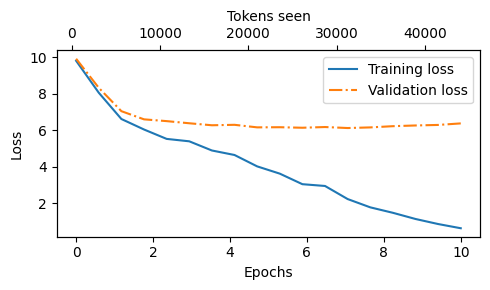

In [ ]:
#TODO
"""
tracer les pertes d entrainement et de validation
variables : epochs_tensor
"""
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

**Temperature Scaling**

In [ ]:
#A modified text generation function with more diversity"""
def generate(model, idx, max_new_tokens, context_size,temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      logits = torch.where(logits < min_val,torch.tensor(float('-inf')).to(logits.device),logits)
    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)
    if idx_next == eos_id:
      break
    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [ ]:
#TODO
model.to("cpu")
model.eval()
torch.manual_seed(123)
"""
generer la suite de la phrase <Every effort moves you> avec consideration de une temperature de 1.4 et top-k de 25
variables : token_ids
"""
token_ids = generate(
    model=model, idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,context_size=GPT_CONFIG_124M["context_length"],top_k=25,temperature=1.4)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to go a little wild--I was such a good; and


In [ ]:
#TODO
"""
experimenter plusieurs valeurs de temperature et de top-k pour les aspets deterministe ou créatif du modèle
"""

'experimenter plusieurs valeurs de temperature et de top-k pour les aspets deterministe ou créatif du modèle'

**Sauvegarde et rechargement du modèle**

In [ ]:
"""saving model and optimizer for later training tasks"""
torch.save({
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
},
"model_and_optimizer.pth"
)



In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

#Atelier 2 : Réglage Fin du LLM pour suivre des instructions

#1 - Loading Pre Trained GPT2 Model Weights

In [ ]:
#Downloading openIA gpt-2 (124M) model
"""Note that OpenAI originally saved the GPT-2 weights via TensorFlow, which we have to install to load the weights in Python. """
!pip install tensorflow>=2.15.0 tqdm>=4.66
"""we download the gpt_download.py Python module directly from online repository"""
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py")
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x783f2c9fc110>)

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, ""Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [ ]:
#GPT Weight copying from original gpt2 to our GPTModel instance
import numpy as np
def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)
    gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight,params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias,params["blocks"][b]["attn"]["c_proj"]["b"])
    gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight,params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias,params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight,params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias,params["blocks"][b]["mlp"]["c_proj"]["b"])
    gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale,params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
    gpt.trf_blocks[b].norm1.shift,params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale,params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift,params["blocks"][b]["ln_2"]["b"])
  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

#2 - Preparation du dataset

In [ ]:
# 3.Downloading and unzipping the dataset
import json
import os
import urllib
def download_and_load_file(file_path, url):
  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
      text_data = response.read().decode("utf-8")
    with open(file_path, "w", encoding="utf-8") as file:
      file.write(text_data)
  else:
    with open(file_path, "r", encoding="utf-8") as file:
      text_data = file.read()
  with open(file_path, "r") as file:
    data = json.load(file)
  return data

file_path = "instruction-data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json")
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [ ]:
#TODO
"""afficher l exemple 50 et l exemple 999, que remarquez vous"""
print("Example entry:\n", data[50])
print("Another example entry:\n", data[999])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [ ]:
#Format inputs
def format_input(entry):
  instruction_text = (
    f"Below is an instruction that describes a task. "
    f"Write a response that appropriately completes the request."
    f"\n\n### Instruction:\n{entry['instruction']}"
  )
  input_text = (
    f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
  )
  return instruction_text + input_text

In [ ]:
#Dataset split
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Previously, the training batches were created automatically by the PyTorch DataLoader class, which employs a default collate function to combine lists of samples into batches. However, the batching process for instruction fine-tuning is a bit more involvedand requires us to create our own custom collate function that we will later plug into the DataLoader.

In [ ]:
#Dataset Set up
class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encoded_texts = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(tokenizer.encode(full_text))
  def __getitem__(self, index):
      return self.encoded_texts[index]
  def __len__(self):
    return len(self.data)

In [ ]:
def custom_collate_fn(batch,pad_token_id=50256,ignore_index=-100,allowed_max_length=None,device="cpu"):
  batch_max_length = max(len(item)+1 for item in batch)
  inputs_lst, targets_lst = [], []
  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]
    padded = (new_item + [pad_token_id] *(batch_max_length - len(new_item)))
    inputs = torch.tensor(padded[:-1])
    targets = torch.tensor(padded[1:])
    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      targets[indices[1:]] = ignore_index
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]
    inputs_lst.append(inputs)
    targets_lst.append(targets)
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor, targets_tensor

In [ ]:
print("Device:", device)
from functools import partial
customized_collate_fn = partial(custom_collate_fn,device=device,allowed_max_length=1024)

Device: cuda


In [ ]:
#Création du dataloader
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=customized_collate_fn,shuffle=True,drop_last=True,
num_workers=num_workers
)
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset,batch_size=batch_size,collate_fn=customized_collate_fn,shuffle=False,drop_last=False,
num_workers=num_workers
)
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset,batch_size=batch_size,collate_fn=customized_collate_fn,shuffle=False,drop_last=False,
num_workers=num_workers
)

In [ ]:
#TODO
"""afficher les taille des entrées et des sorties du data loader d'entrainement pour chaque batche"""
print("Train loader:")
for inputs, targets in train_loader:
  print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [ ]:
#loading gpt 2 -medium weights
"""load the GPT-2 architecture settings (settings) and weight parameters (params) into our Python session"""
from gpt_download import download_and_load_gpt2
BASE_CONFIG = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"drop_rate": 0.0, # Dropout rate
"qkv_bias": True # Query-key-value bias
}
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size,models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 195kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.74MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 146kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:33<00:00, 15.2MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 13.2MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 3.10MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.80MiB/s]


In [ ]:
#TODO
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

token_ids = generate(model=model,idx=text_to_token_ids(input_text, tokenizer),
max_new_tokens=35,context_size=BASE_CONFIG["context_length"], eos_id=50256,)
generated_text = token_ids_to_text(token_ids, tokenizer)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
#TODO
response_text = generated_text[len(input_text):].strip()
print(response_text)


### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


# 3 - Fine-tuning the LLM on instruction data

In [ ]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
  val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909471511841
Validation loss: 3.761934232711792


In [ ]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

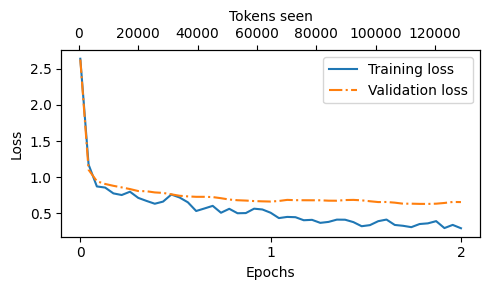

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(
  epochs_seen, val_losses, linestyle="-.", label="Validation loss"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# 4 - Extraction et sauvegarde des réponses

In [ ]:
#TODO
torch.manual_seed(123)
for entry in test_data[:3]:
  input_text = format_input(entry)
  token_ids = generate(
  model=model,
  idx=text_to_token_ids(input_text, tokenizer).to(device),
  max_new_tokens=256,
  context_size=BASE_CONFIG["context_length"],
  eos_id=50256
  )
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = (
  generated_text[len(input_text):]
  .replace("### Response:", "")
  .strip()
  )
  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

In [ ]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
  input_text = format_input(entry)
  token_ids = generate(
  model=model,
  idx=text_to_token_ids(input_text, tokenizer).to(device),
  max_new_tokens=256,
  context_size=BASE_CONFIG["context_length"],
  eos_id=50256
  )
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = (
  generated_text[len(input_text):]
  .replace("### Response:", "")
  .strip()
  )
  test_data[i]["model_response"] = response_text
with open("instruction-data-with-response.json", "w") as file:
  json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:15<00:00,  1.46it/s]


In [ ]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [ ]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")
#model.load_state_dict(torch.load("gpt2-medium355M-sft.pth")).

Model saved as gpt2-medium355M-sft.pth


# 5 - Evaluation du LLM